<a href="https://colab.research.google.com/github/aronsalinas96/tensorflow_basics/blob/main/04_Transfer_learning_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. Can leverage an existing neural network architecture proven to work on problems similar to own.
2.  Can leverage an existing neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-02-14 12:04:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 173.194.198.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   160MB/s    in 1.0s    

2022-02-14 12:04:21 (160 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [4]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2

In [5]:
import tensorflow_hub as hub 
from tensorflow.keras import layers 

In [6]:
def create_model(model_url, num_classes=10):
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)
                                           )
  model = tf.keras.Sequential([
                               feature_extraction_layer,
                               layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [7]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [10]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                        experiment_name="resnet50V2")
                                  ])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220214-120444
Epoch 1/5
24/24 [==============================] - 490s 21s/step - loss: 1.8729 - accuracy: 0.3880 - val_loss: 1.1245 - val_accuracy: 0.6540
Epoch 2/5
24/24 [==============================] - 483s 21s/step - loss: 0.8483 - accuracy: 0.7587 - val_loss: 0.7989 - val_accuracy: 0.7512
Epoch 3/5
24/24 [==============================] - 448s 19s/step - loss: 0.5839 - accuracy: 0.8387 - val_loss: 0.7160 - val_accuracy: 0.7732
Epoch 4/5
24/24 [==============================] - 484s 21s/step - loss: 0.4534 - accuracy: 0.8960 - val_loss: 0.6704 - val_accuracy: 0.7912
Epoch 5/5
24/24 [==============================] - 435s 19s/step - loss: 0.3628 - accuracy: 0.9280 - val_loss: 0.6432 - val_accuracy: 0.8004


In [14]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

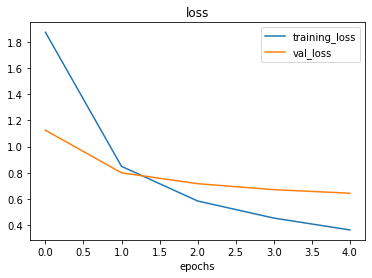

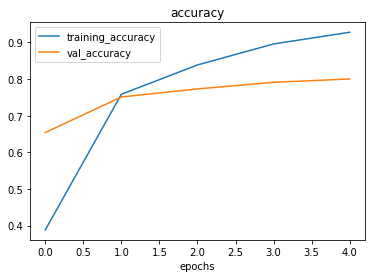

In [16]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [17]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow/efficientnetb0/20220214-125718
Epoch 1/5
24/24 [==============================] - 176s 7s/step - loss: 1.8151 - accuracy: 0.5027 - val_loss: 1.2677 - val_accuracy: 0.7396
Epoch 2/5
24/24 [==============================] - 160s 7s/step - loss: 1.0298 - accuracy: 0.7893 - val_loss: 0.8471 - val_accuracy: 0.8140
Epoch 3/5
24/24 [==============================] - 179s 8s/step - loss: 0.7339 - accuracy: 0.8453 - val_loss: 0.6863 - val_accuracy: 0.8380
Epoch 4/5
24/24 [==============================] - 160s 7s/step - loss: 0.5905 - accuracy: 0.8787 - val_loss: 0.6050 - val_accuracy: 0.8516
Epoch 5/5
24/24 [==============================] - 160s 7s/step - loss: 0.5021 - accuracy: 0.8867 - val_loss: 0.5537 - val_accuracy: 0.8576


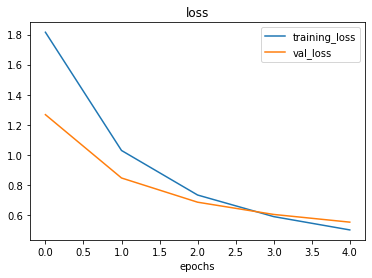

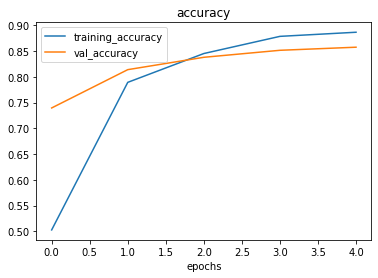

In [18]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever.
* **Feature extraction** transfer learning - use the prelearned patterns of an existing model and adjust the output layer for your own problem.
* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers

## Comparintg models results using TensorBoard

**Note**: When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard dev.

In [19]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50V2 - 2022" \
  --description "Comparing two different TF Hub Feature extraction model architectures" \
  --one_shot

2022-02-14 13:25:38.875640: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%

In [20]:
!tensorboard dev list

2022-02-14 13:28:06.786165: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
https://tensorboard.dev/experiment/jlmlH4rZQgSlndoVkDb6Cw/
	Name                 EfficientNetB0 vs ResNet50V2 - 2022
	Description          Comparing two different TF Hub Feature extraction model architectures
	Id                   jlmlH4rZQgSlndoVkDb6Cw
	Created              2022-02-14 13:26:12 (2 minutes ago)
	Updated              2022-02-14 13:26:13 (2 minutes ago)
	Runs                 2
	Tags                 5
	Scalars              30
	Tensor bytes         0
	Binary object bytes  1843756
Total: 1 experiment(s)


In [21]:
!tensorboard dev delete --experiment_id jlmlH4rZQgSlndoVkDb6Cw #Delete project with Id

2022-02-14 13:29:01.830177: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Deleted experiment jlmlH4rZQgSlndoVkDb6Cw.
